In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
road = pd.read_csv('/content/drive/MyDrive/data capstone/Road Accident Data 2.csv')

In [ ]:
road.dropna(inplace=True)

In [ ]:
road['Time'] = road['Time'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

In [ ]:
#show all rows
pd.set_option('display.max_rows', None)

In [ ]:
categorical = road.select_dtypes(include=['object'])
numerical = road.select_dtypes(exclude=['object'])

In [ ]:
target = road['Accident_Severity']
categorical = categorical.drop('Accident_Severity', axis=1)

In [ ]:
target.value_counts()

,count
Accident_Severity,
Slight,4461
Serious,771
Fatal,73


In [ ]:
categorical.drop('Accident_Index',axis= 1, inplace = True)
categorical.drop('Accident Date', axis=1, inplace=True)
#categorical.drop('Time', axis=1, inplace=True)
categorical.drop('Local_Authority_(District)', axis=1, inplace=True)
categorical.drop('Police_Force', axis=1, inplace=True)

In [ ]:
categorical = pd.get_dummies(categorical, drop_first=True)
categorical = categorical.astype(int)

In [ ]:
target = target.map({'Slight': 0, 'Serious': 1, 'Fatal': 2})

In [ ]:
df = pd.concat([categorical,numerical,target], axis=1)

In [ ]:
target = df['Accident_Severity']
predictors = df.drop('Accident_Severity', axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, random_state=42)

In [ ]:
sm = SMOTE(
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5,
)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [ ]:
x_train.shape, x_train_res.shape

((3713, 74), (9348, 74))

In [ ]:
numerical1 = x_train_res[numerical.columns]

In [ ]:
categorical1 = x_train_res.drop(numerical.columns, axis=1)

In [ ]:
target1 = y_train_res

In [ ]:
train_df = pd.concat([categorical1,numerical1,target1], axis=1)

In [ ]:
mean = train_df[numerical.columns].mean()
std = train_df[numerical.columns].std()

In [ ]:
train_df[numerical.columns] = (train_df[numerical.columns] - mean) / std

In [ ]:
x_test[numerical.columns] = (x_test[numerical.columns] - mean) / std

In [ ]:
df1 = train_df

In [ ]:
target = y_train_res
predictors = df1.drop('Accident_Severity', axis=1)

In [ ]:
predictors.shape, target.shape

((9348, 74), (9348,))

In [ ]:
df1['Accident_Severity'].value_counts()

,count
Accident_Severity,
1,3116
0,3116
2,3116


gbm

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [ ]:
gbm.fit(predictors, target)

GradientBoostingClassifier(random_state=42)

In [ ]:
gbm_pred = gbm.predict(x_test)

In [ ]:
gbm_acc = accuracy_score(y_test, gbm_pred)
gbm_acc

0.7782663316582915

<Axes: xlabel='Predicted', ylabel='Actual'>

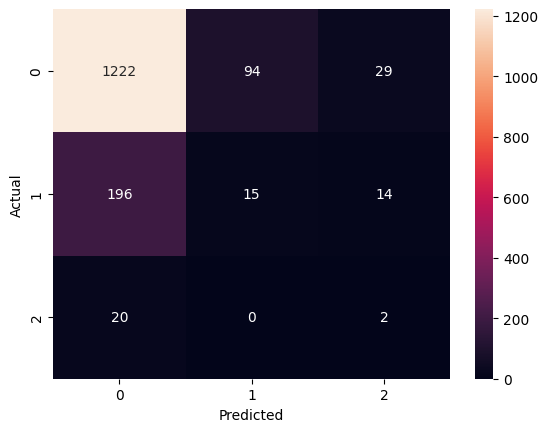

In [ ]:
sns.heatmap(pd.crosstab(y_test, gbm_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')

**cross validation for gbm**

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Accuracy: 0.9174269748757521
Test Accuracy: 0.8128140703517588


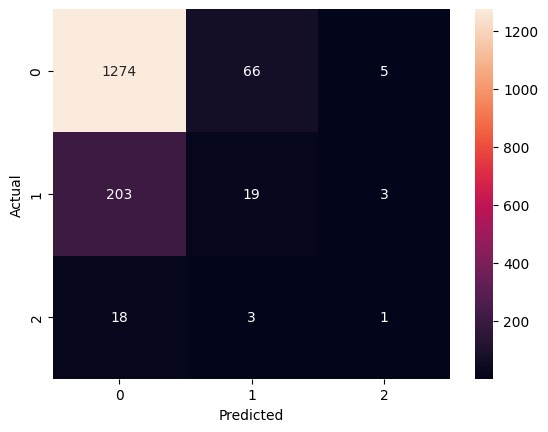

In [ ]:
# prompt: create a 5 fold cross validation for different hyperparameters for the gbm

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

# Initialize the GradientBoostingClassifier
gbm = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(predictors, target)

# Print the best hyperparameters and the corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Get the best model
best_gbm = grid_search.best_estimator_

# Evaluate the best model on the test set
best_gbm_pred = best_gbm.predict(x_test)
best_gbm_acc = accuracy_score(y_test, best_gbm_pred)
print("Test Accuracy:", best_gbm_acc)

# Visualize the confusion matrix for the best model
sns.heatmap(pd.crosstab(y_test, best_gbm_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')
plt.show()


In [ ]:
#show all columns
pd.set_option('display.max_columns', None)

In [ ]:
# prompt: feature importance in order for gbm

import pandas as pd
importances = gbm.feature_importances_
feature_names = predictors.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df


,Feature,Importance
44,Road_Type_Single carriageway,0.116044
73,Time,0.110755
72,Speed_limit,0.105491
67,Year,0.082262
46,Urban_or_Rural_Area_Urban,0.066086
71,Number_of_Vehicles,0.051863
18,Junction_Control_Data missing or out of range,0.037698
19,Junction_Control_Give way or uncontrolled,0.036629
15,Day_of_Week_Tuesday,0.029087
14,Day_of_Week_Thursday,0.028786


In [ ]:
gbm_variables = predictors.copy()

Accuracy of the reduced GBM model: 0.7518844221105527


<Axes: xlabel='Predicted', ylabel='Actual'>

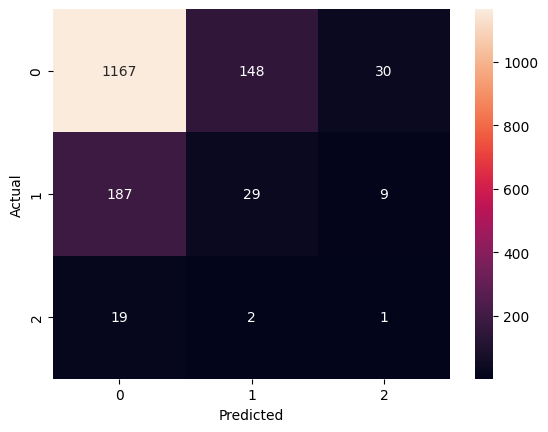

In [ ]:
# prompt: drop the 40 least important variables and refit the gbm with the remaining variables

import pandas as pd
# Get the 40 least important features
least_important_features = importance_df.tail(50)['Feature'].values

# Drop the least important features from the predictors
predictors_reduced = predictors.drop(columns=least_important_features)

# Refit the GBM model with the remaining variables
gbm_reduced = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_reduced.fit(predictors_reduced, target)

# Make predictions on the test set using the refitted model
gbm_reduced_pred = gbm_reduced.predict(x_test.drop(columns=least_important_features))

# Evaluate the accuracy of the refitted model
gbm_reduced_acc = accuracy_score(y_test, gbm_reduced_pred)
print(f"Accuracy of the reduced GBM model: {gbm_reduced_acc}")

# You can further analyze the performance of the reduced model using other metrics or visualizations.
sns.heatmap(pd.crosstab(y_test, gbm_reduced_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')


In [ ]:
predictors_reduced.columns

Index(['Month_Jan', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'Day_of_Week_Monday', 'Day_of_Week_Saturday', 'Day_of_Week_Sunday',
       'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday',
       'Junction_Control_Data missing or out of range',
       'Junction_Control_Give way or uncontrolled',
       'Junction_Control_Not at junction or within 20 metres',
       'Light_Conditions_Darkness - no lighting',
       'Road_Surface_Conditions_Wet or damp', 'Road_Type_Single carriageway',
       'Urban_or_Rural_Area_Urban', 'Weather_Conditions_Fine no high winds',
       'Year', 'Latitude', 'Longitude', 'Number_of_Vehicles', 'Speed_limit',
       'Time'],
      dtype='object')

Accuracy of the reduced GBM model: 0.7374371859296482


<Axes: xlabel='Predicted', ylabel='Actual'>

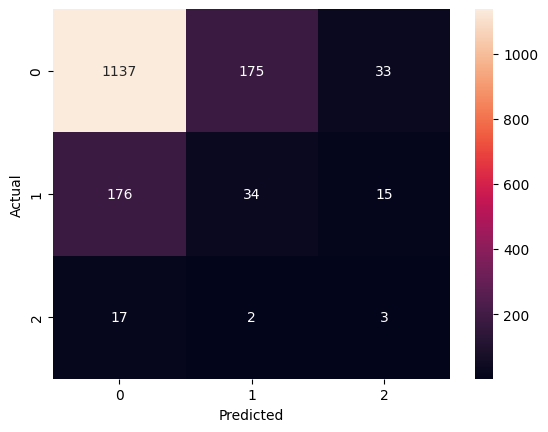

In [ ]:
import pandas as pd
# Get the 40 least important features
least_important_features = importance_df.tail(55)['Feature'].values

# Drop the least important features from the predictors
predictors_reduced = predictors.drop(columns=least_important_features)

# Refit the GBM model with the remaining variables
gbm_reduced = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_reduced.fit(predictors_reduced, target)

# Make predictions on the test set using the refitted model
gbm_reduced_pred = gbm_reduced.predict(x_test.drop(columns=least_important_features))

# Evaluate the accuracy of the refitted model
gbm_reduced_acc = accuracy_score(y_test, gbm_reduced_pred)
print(f"Accuracy of the reduced GBM model: {gbm_reduced_acc}")

# You can further analyze the performance of the reduced model using other metrics or visualizations.
sns.heatmap(pd.crosstab(y_test, gbm_reduced_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')


In [ ]:
predictors_reduced.columns

Index(['Month_Nov', 'Day_of_Week_Monday', 'Day_of_Week_Saturday',
       'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday',
       'Junction_Control_Data missing or out of range',
       'Junction_Control_Give way or uncontrolled',
       'Junction_Control_Not at junction or within 20 metres',
       'Road_Surface_Conditions_Wet or damp', 'Road_Type_Single carriageway',
       'Urban_or_Rural_Area_Urban', 'Weather_Conditions_Fine no high winds',
       'Year', 'Latitude', 'Longitude', 'Number_of_Vehicles', 'Speed_limit',
       'Time'],
      dtype='object')

**variable importance plots**

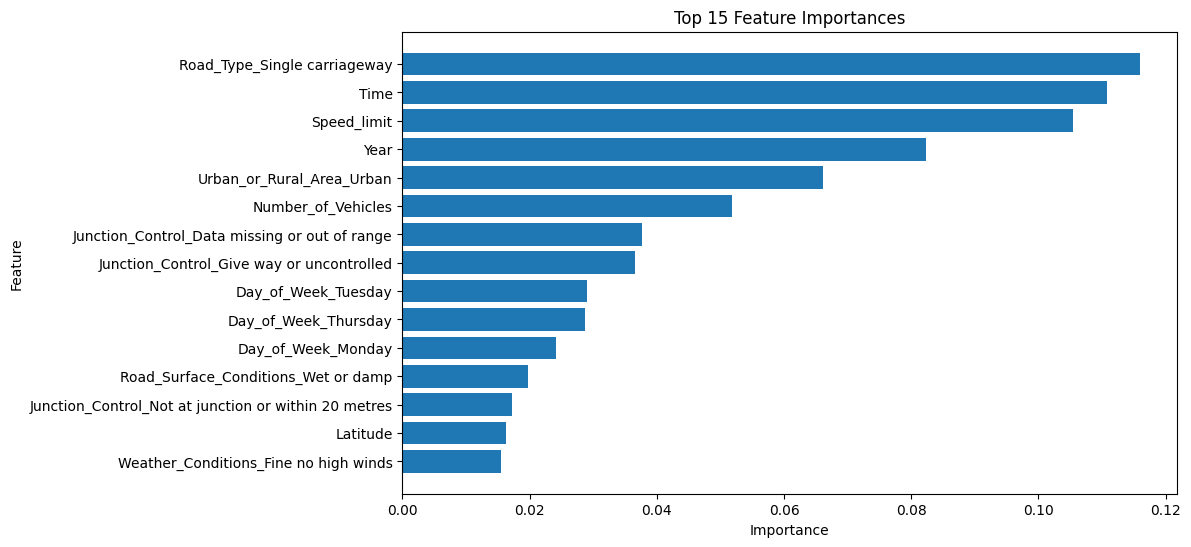

In [ ]:
import matplotlib.pyplot as plt

top_15_features = importance_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()


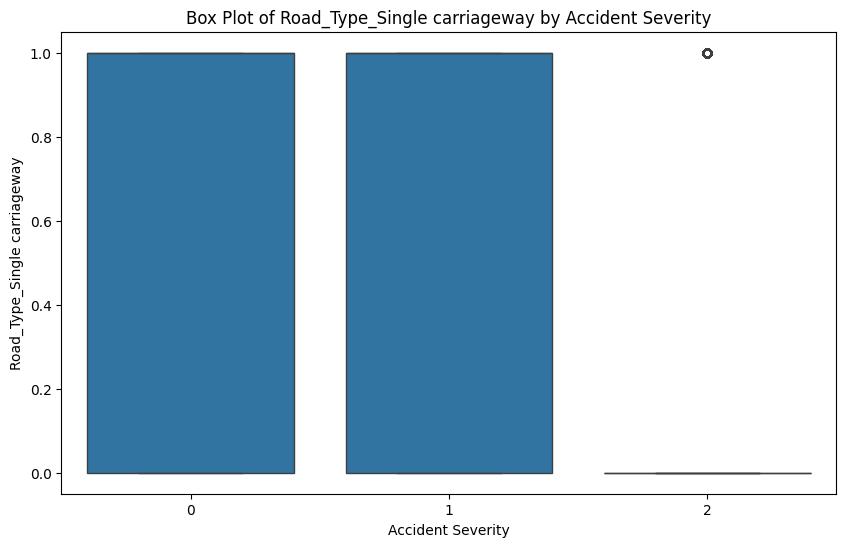

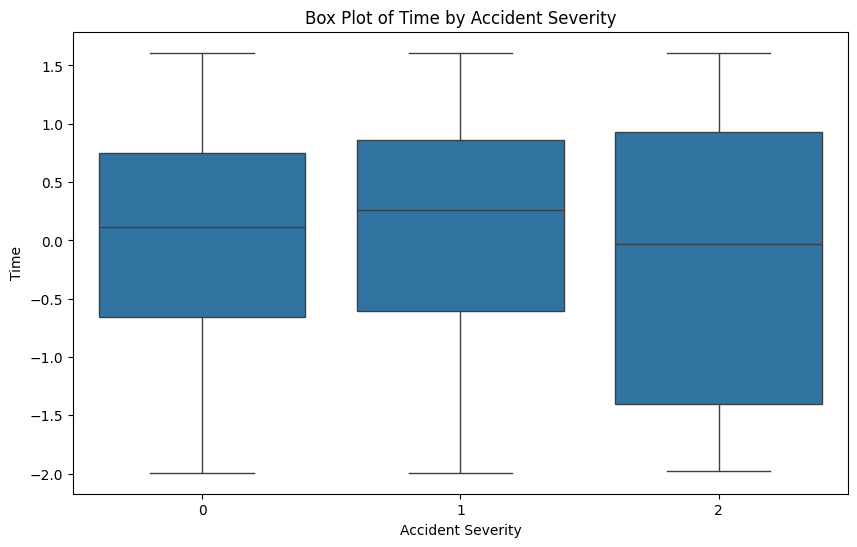

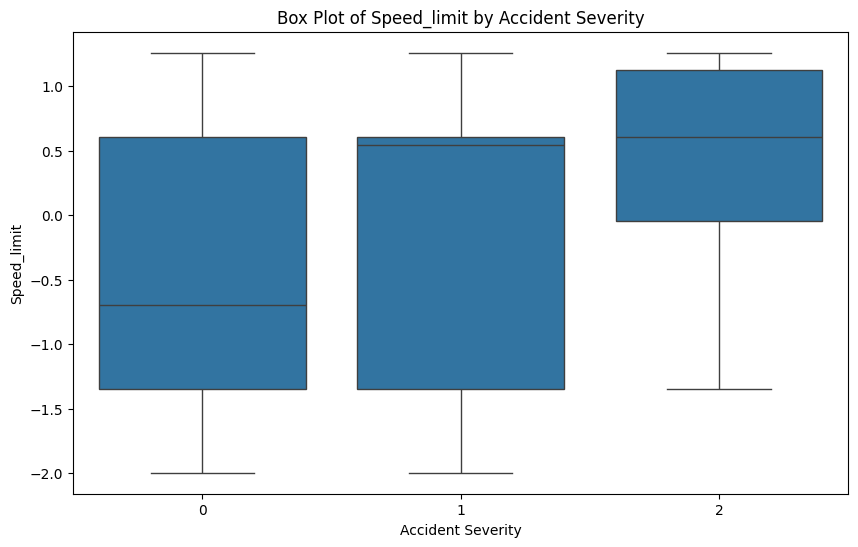

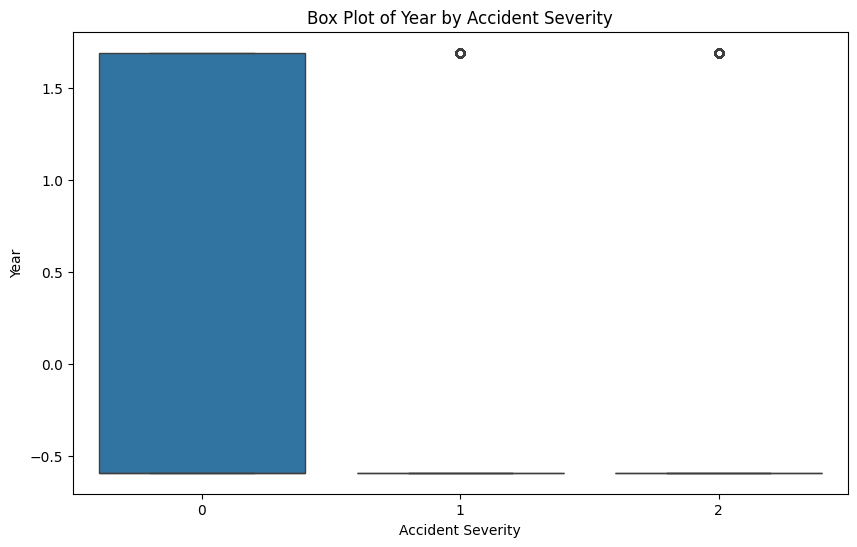

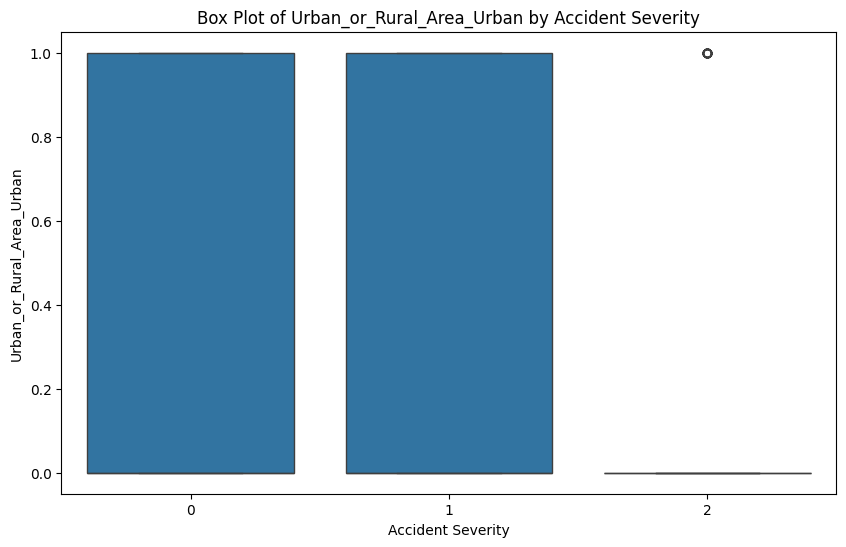

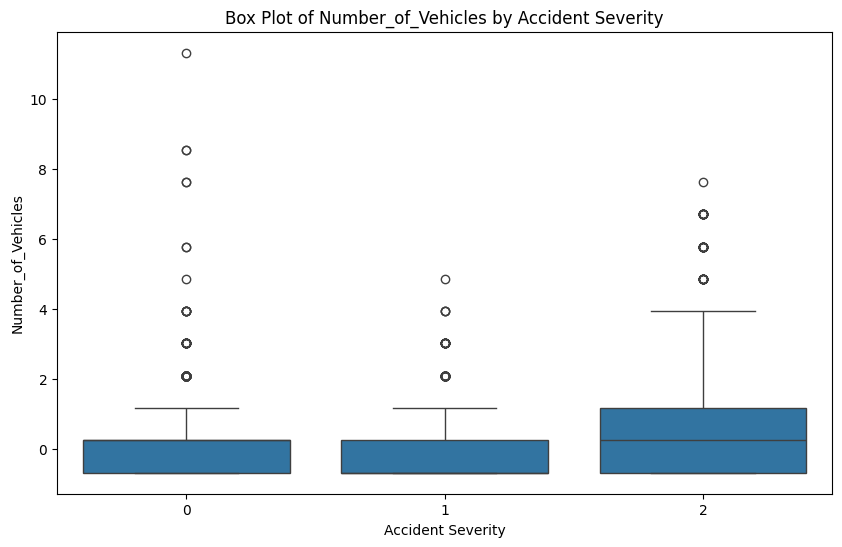

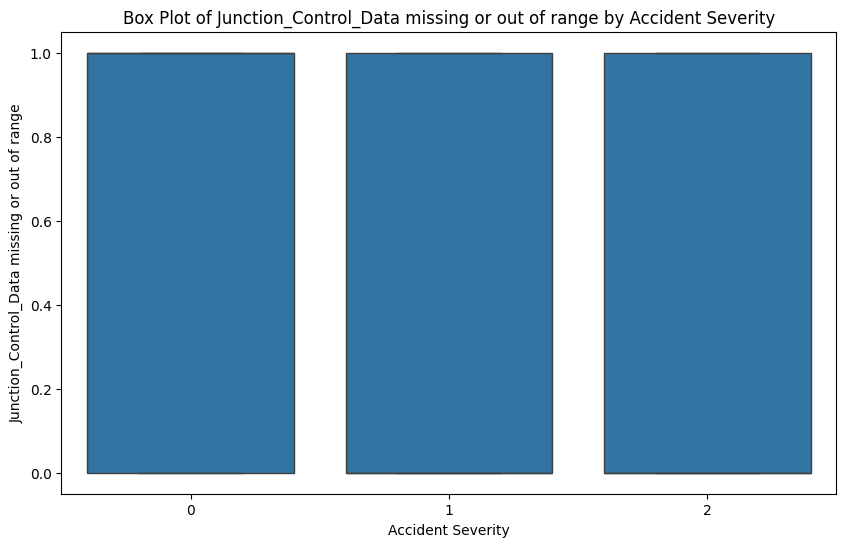

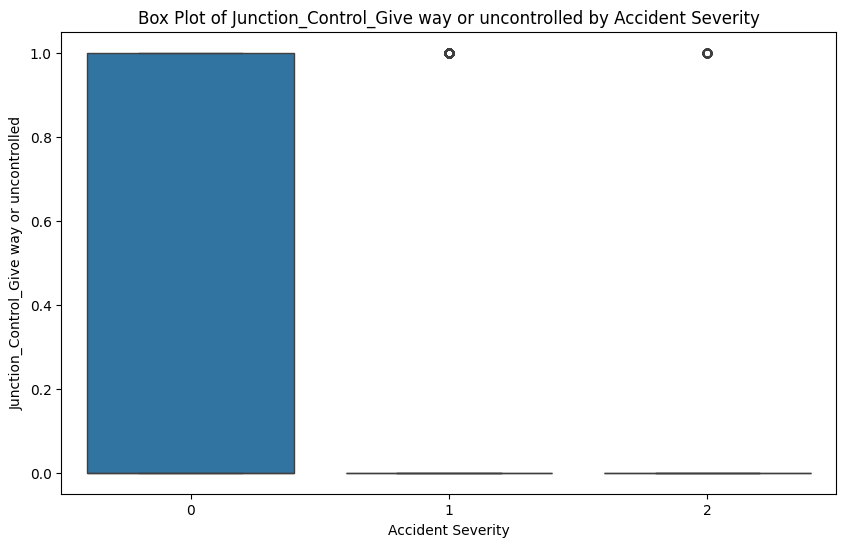

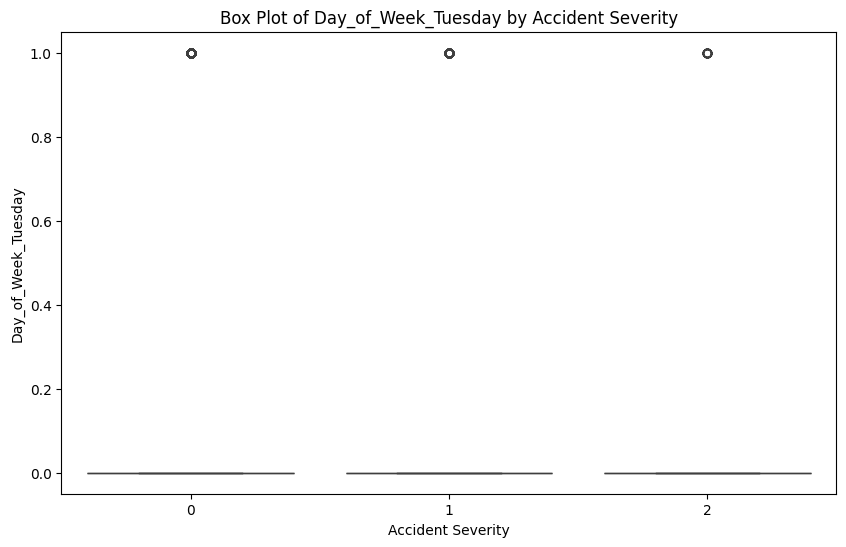

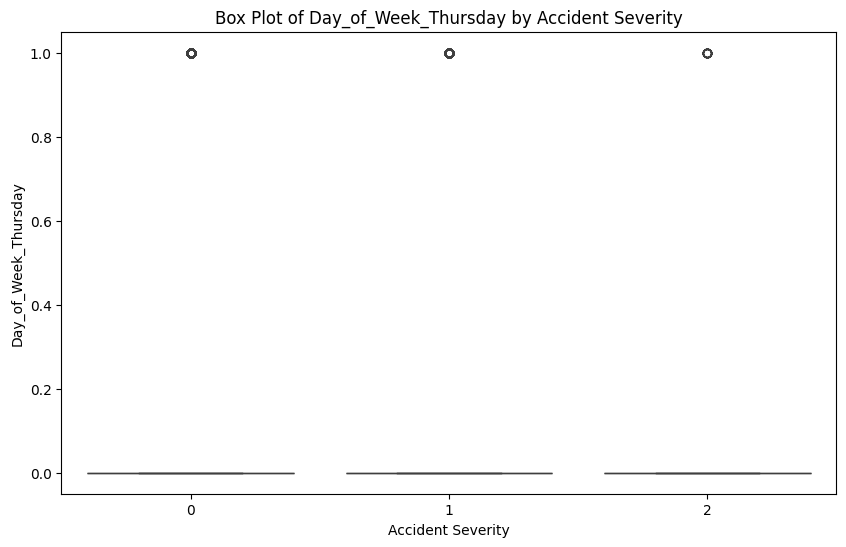

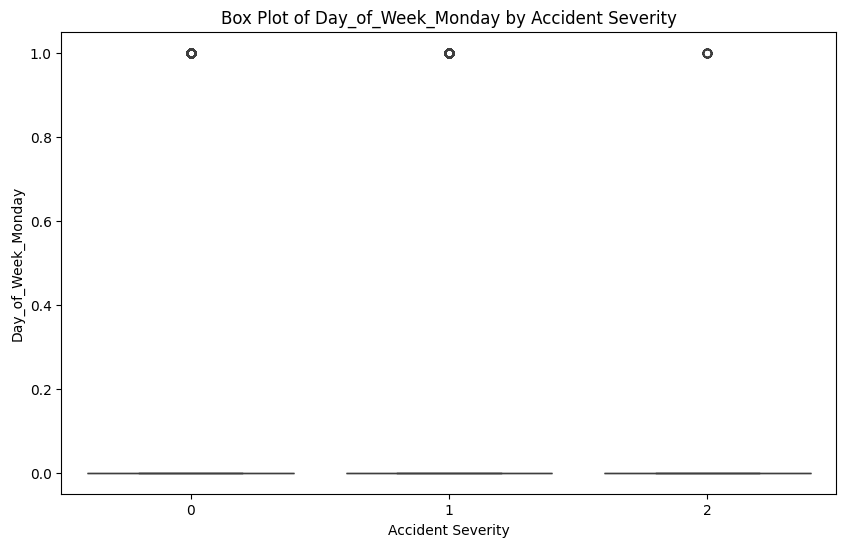

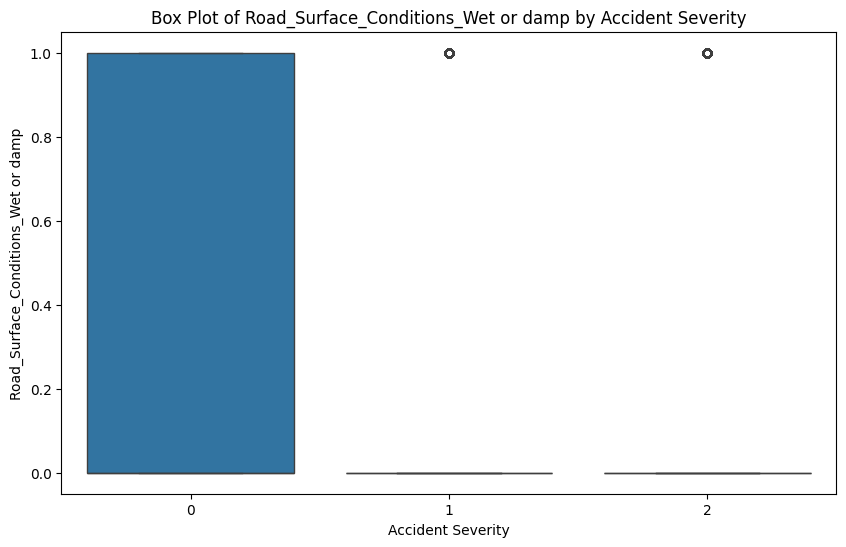

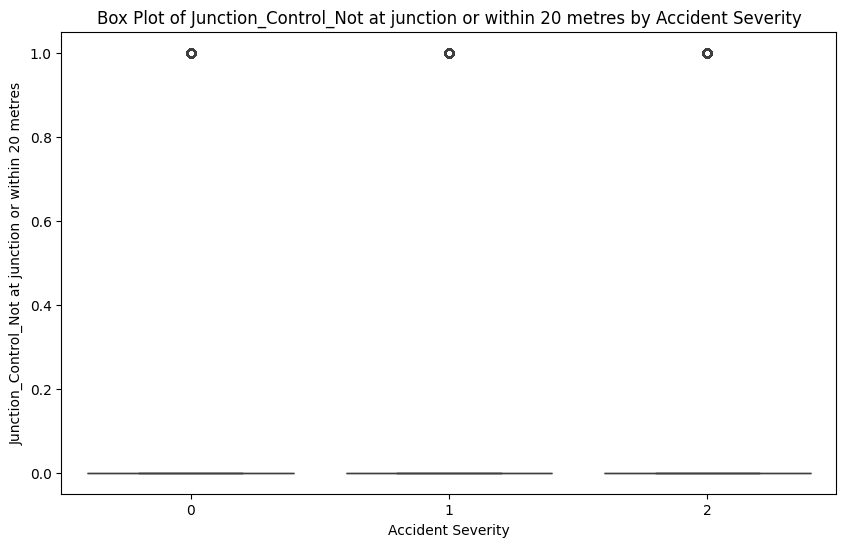

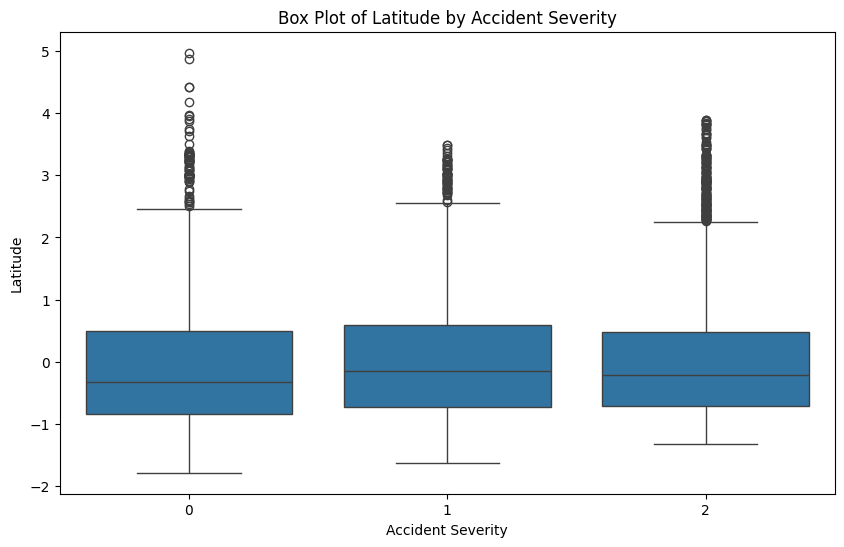

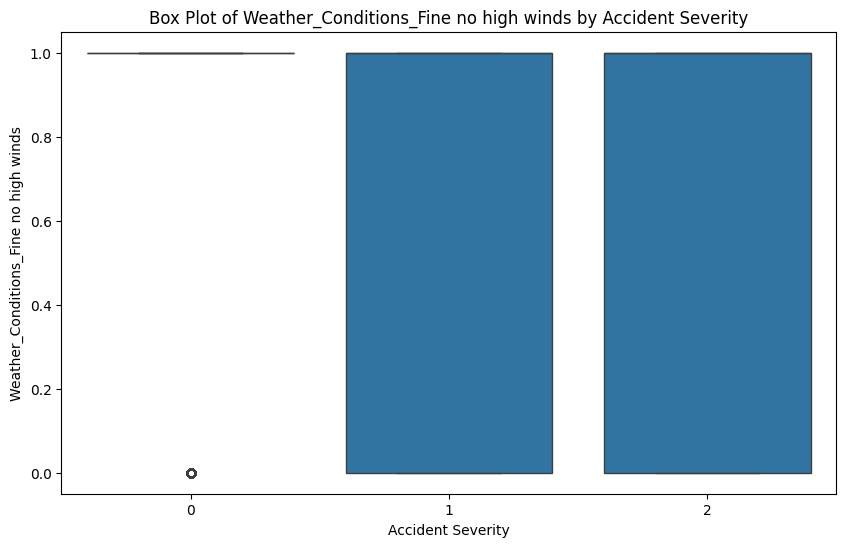

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

top_15_features = importance_df.head(15)['Feature'].tolist()

for feature in top_15_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Accident_Severity', y=feature, data=pd.concat([predictors_reduced[feature], target], axis=1))
    plt.title(f'Box Plot of {feature} by Accident Severity')
    plt.xlabel('Accident Severity')
    plt.ylabel(feature)
    plt.show()


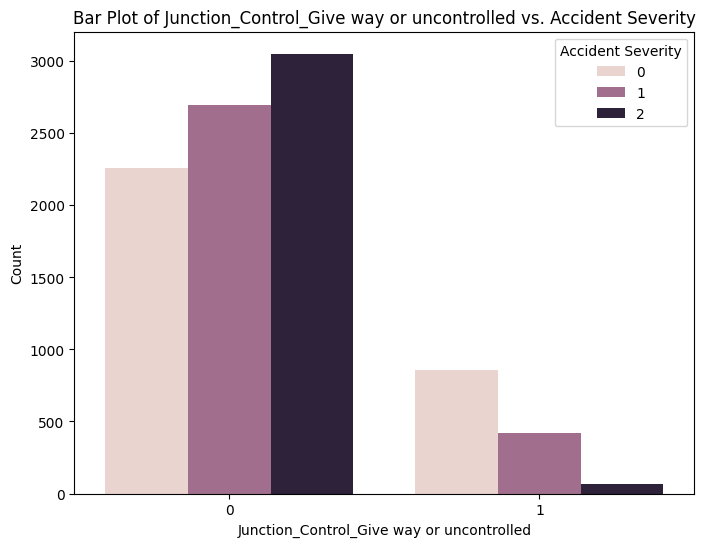

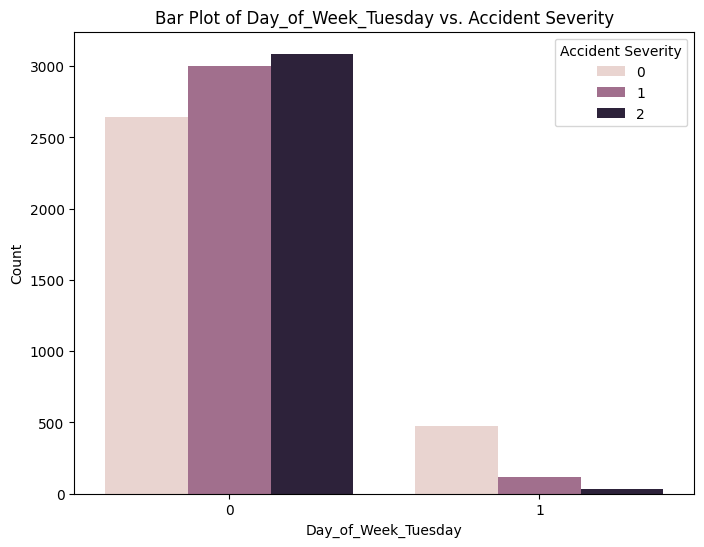

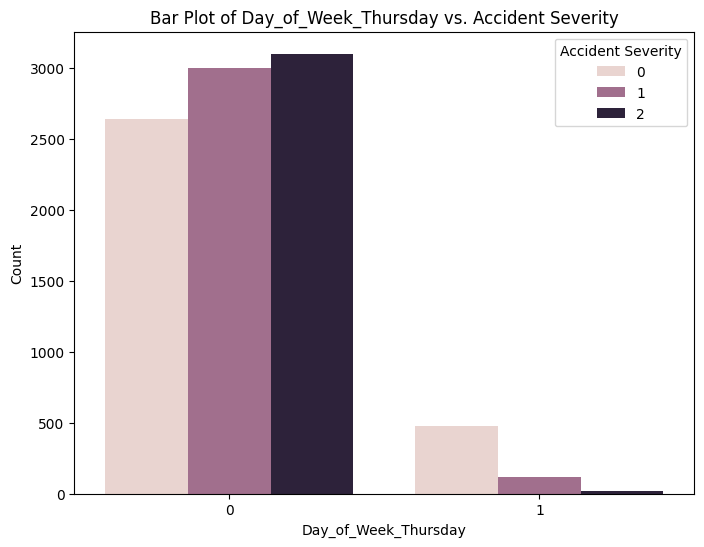

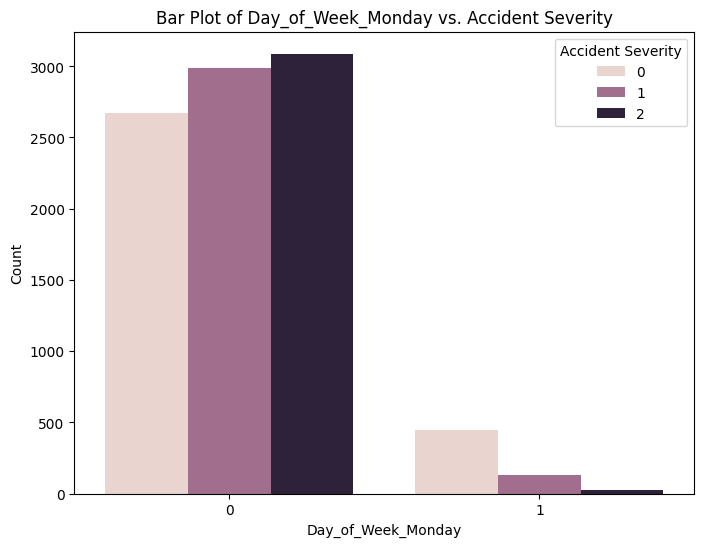

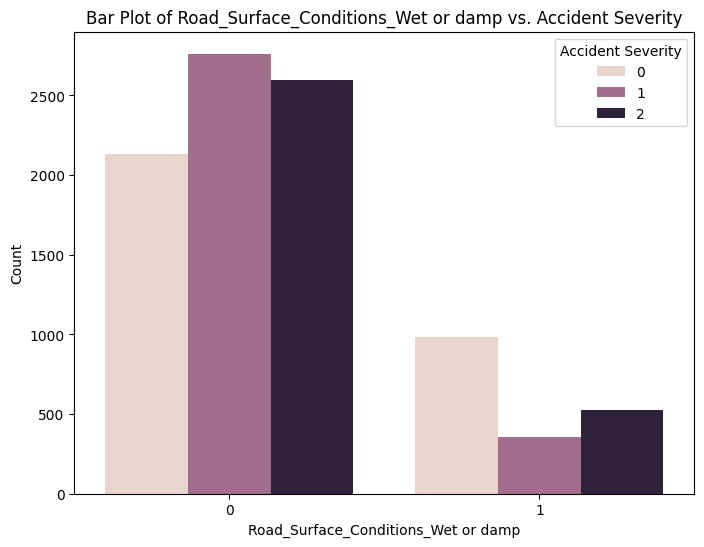

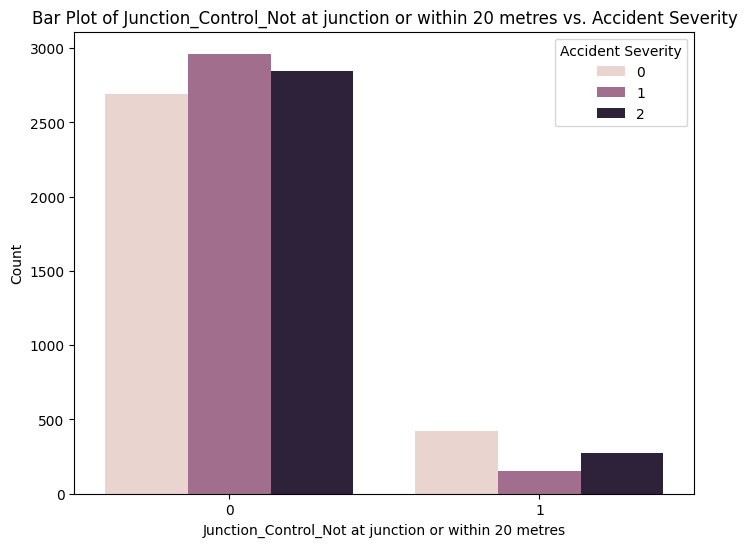

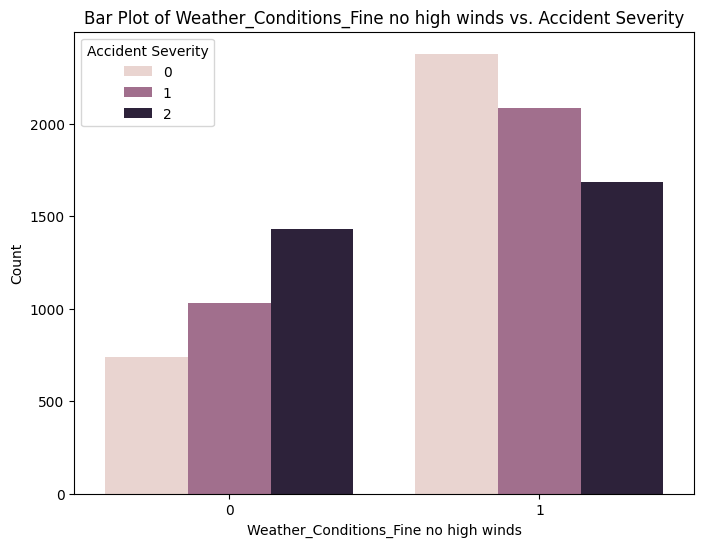

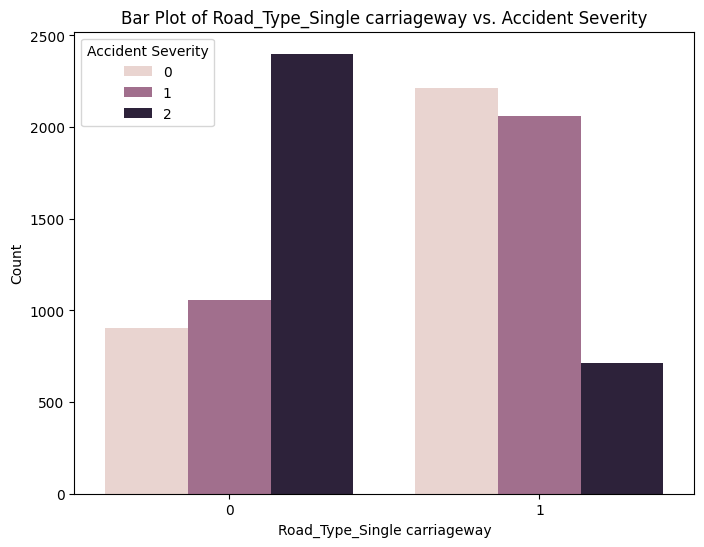

In [ ]:
# prompt: create bar plots for these predictors_reduced[['Junction_Control_Data misssing or out of range'],['Junction_Control_Give way or uncontrolled'],['Day_of_Week_Tuesday'],['Day_of_Week_Thursday'],['Day_of_Week_Monday'],['Road_Surface_Conditions_Wet or damp'],['Junction_Control_Not at junction or within 20 metres'],['Weather_Conditions_Fine no high winds']] against the accident severity

import pandas as pd
import matplotlib.pyplot as plt
# Create bar plots for selected predictors against accident severity
selected_predictors = ['Junction_Control_Data misssing or out of range',
                       'Junction_Control_Give way or uncontrolled',
                       'Day_of_Week_Tuesday',
                       'Day_of_Week_Thursday',
                       'Day_of_Week_Monday',
                       'Road_Surface_Conditions_Wet or damp',
                       'Junction_Control_Not at junction or within 20 metres',
                       'Weather_Conditions_Fine no high winds','Road_Type_Single carriageway']

for predictor in selected_predictors:
    if predictor in predictors_reduced.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(x=predictor, hue='Accident_Severity', data=pd.concat([predictors_reduced[predictor], target], axis=1))
        plt.title(f'Bar Plot of {predictor} vs. Accident Severity')
        plt.xlabel(predictor)
        plt.ylabel('Count')
        plt.legend(title='Accident Severity')
        plt.show()
    else:
        print(f"Warning: Predictor '{predictor}' not found in predictors_reduced DataFrame.")
